# Appendix I

# UNet vs. ResNet Performance

# Library Imports

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ajpe5d04
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ajpe5d04
  Created wheel for tensorflow-examples: filename=tensorflow_examples-b88cccc17e58281b8881feb0b9fb0385b8017e24_-cp37-none-any.whl size=270921 sha256=0e39cd352f2cc24d22ab167fec98dc57fef57edd9c4ca0ced9d5392be11ae4d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-9pkhy3d9/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Dataset Download

In [4]:
# Oxford IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteUK50NY/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteUK50NY/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


# Data Preprocessing

In [5]:
# dataset normalization
# change pixel values from [0, 255] to [0, 1]
# change mask values from {1, 2, 3} to {0, 1, 2}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [6]:
# training data point load with data augmentation
# flip the image
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
# test data point load
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
input_shape = (128,128,3)
num_classes = 3

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
# test, train data set creation
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# Data Exploration

In [12]:
# plot the image and mask
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

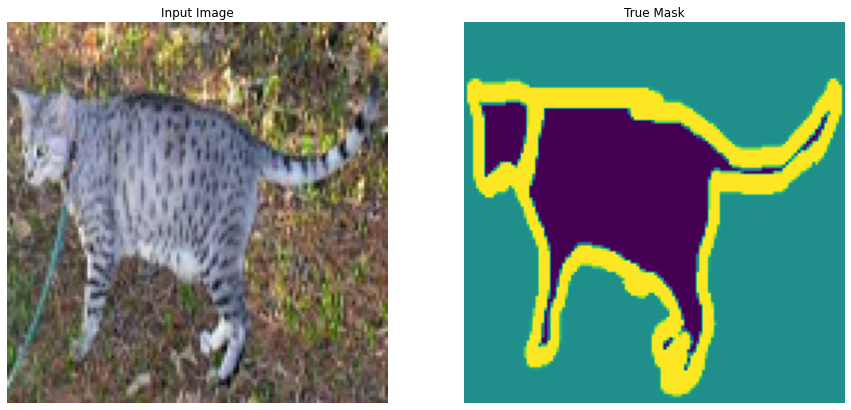

In [13]:
for image, mask in train.take(100):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# U-Net

## U-Net based segmentation model

In [14]:
OUTPUT_CHANNELS = 3

# MobileNetV2 model for Unet
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the UNet

In [17]:
# model_unet is the unet model built with unet functions above 
model_unet = unet_model(OUTPUT_CHANNELS)
model_unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

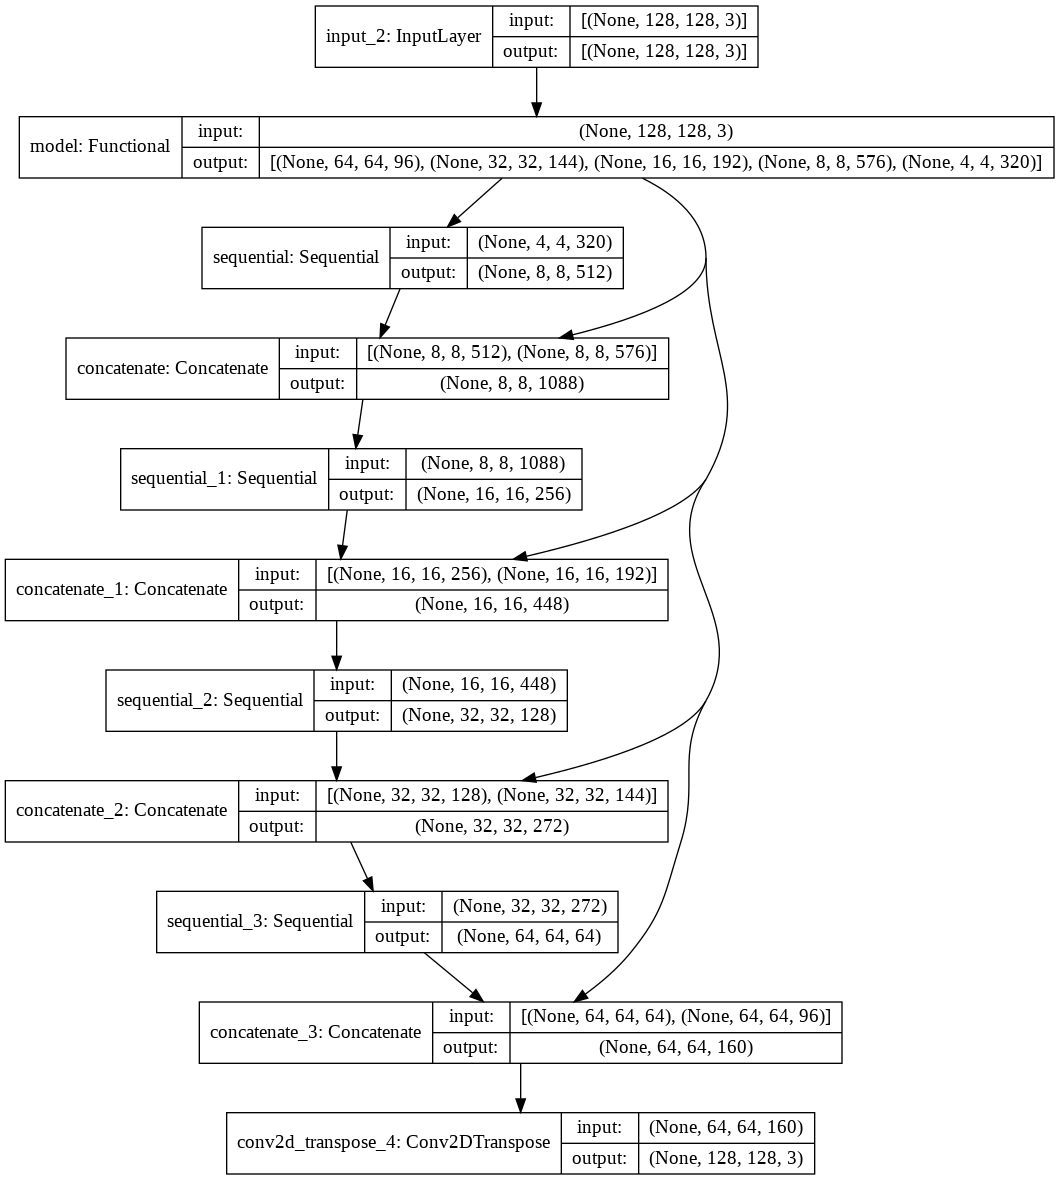

In [18]:
# model_unet diagram
tf.keras.utils.plot_model(model_unet, show_shapes=True)

In [19]:
# summary of the unet model
model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

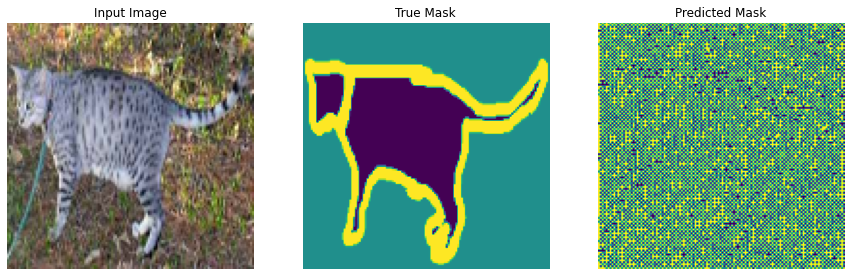

In [21]:
# untrained model predictions
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=0):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_unet.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

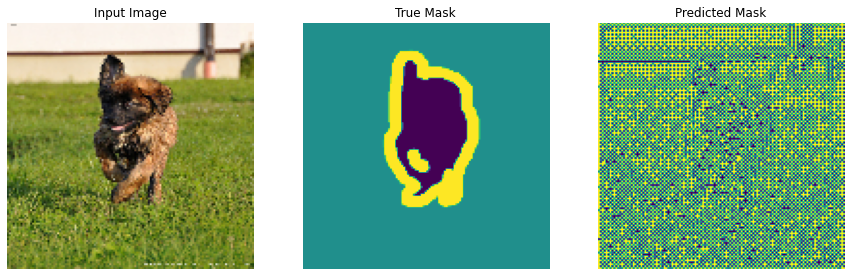

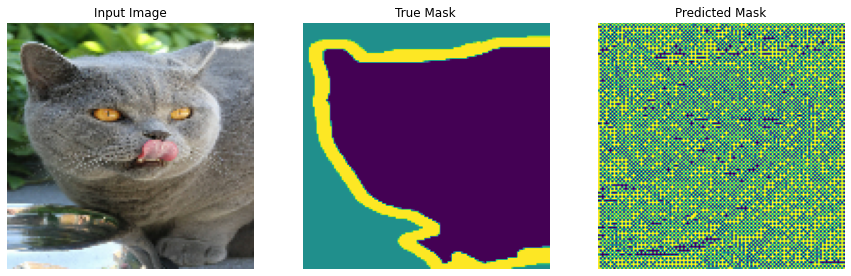

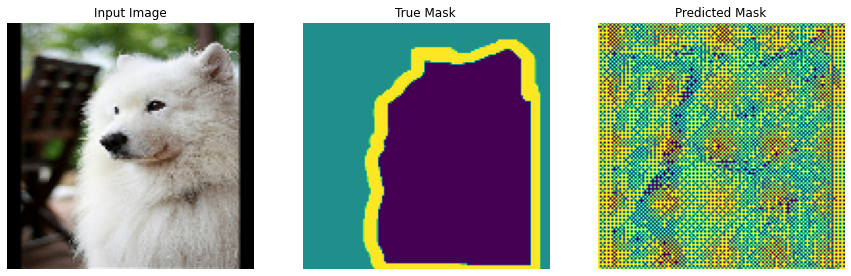

In [22]:
# results of untrained net on test images
show_predictions(test_dataset, 3)

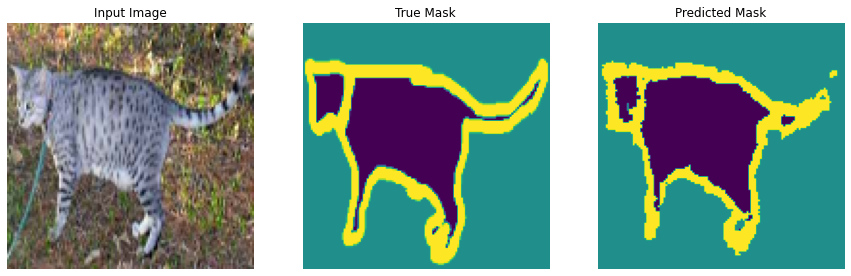


Sample Prediction after epoch 20



In [23]:
# model_unet training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

unet_history = model_unet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

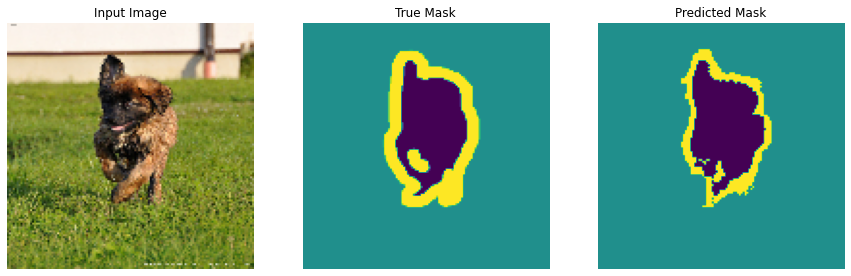

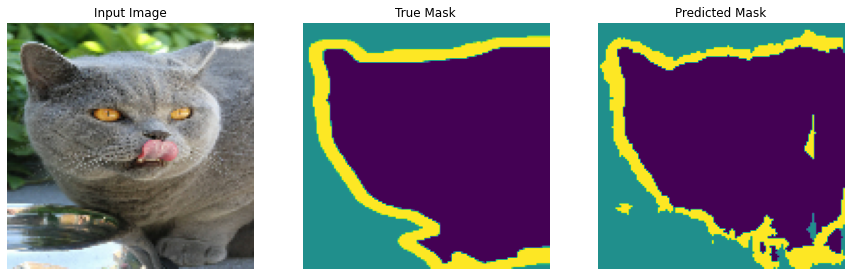

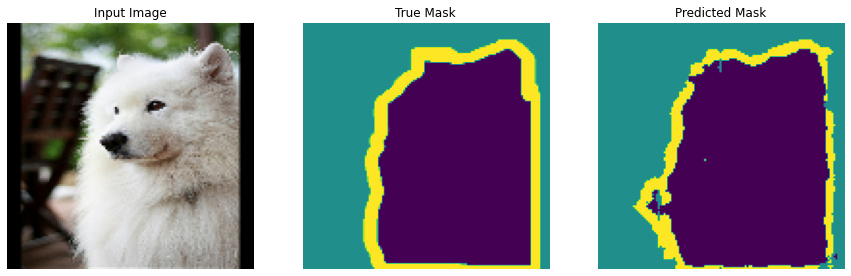

In [24]:
# trained unet predictions
show_predictions(test_dataset, 3)

# ResNet

## Library imports

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential

## ResNet-based segmentation model

In [26]:
base_model_rn = tf.keras.applications.ResNet50(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'conv1_conv',         # 64x64
    'conv2_block3_out',   # 32x32
    'conv3_block4_out',   # 16x16
    'conv4_block6_out',   # 8x8
    'conv5_block3_out',   # 4x4
]
base_model_rn_outputs = [base_model_rn.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack_rn = tf.keras.Model(inputs=base_model_rn.input, outputs=base_model_rn_outputs)

down_stack_rn.trainable = False


94773248/94765736 [==============================] - 1s 0us/step


In [27]:
up_stack_rn = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [28]:
def resnet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack_rn(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack_rn, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the ResNet

In [29]:
# model_resnet is the unet model built with unet functions above 
model_resnet = resnet_model(OUTPUT_CHANNELS)
model_resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

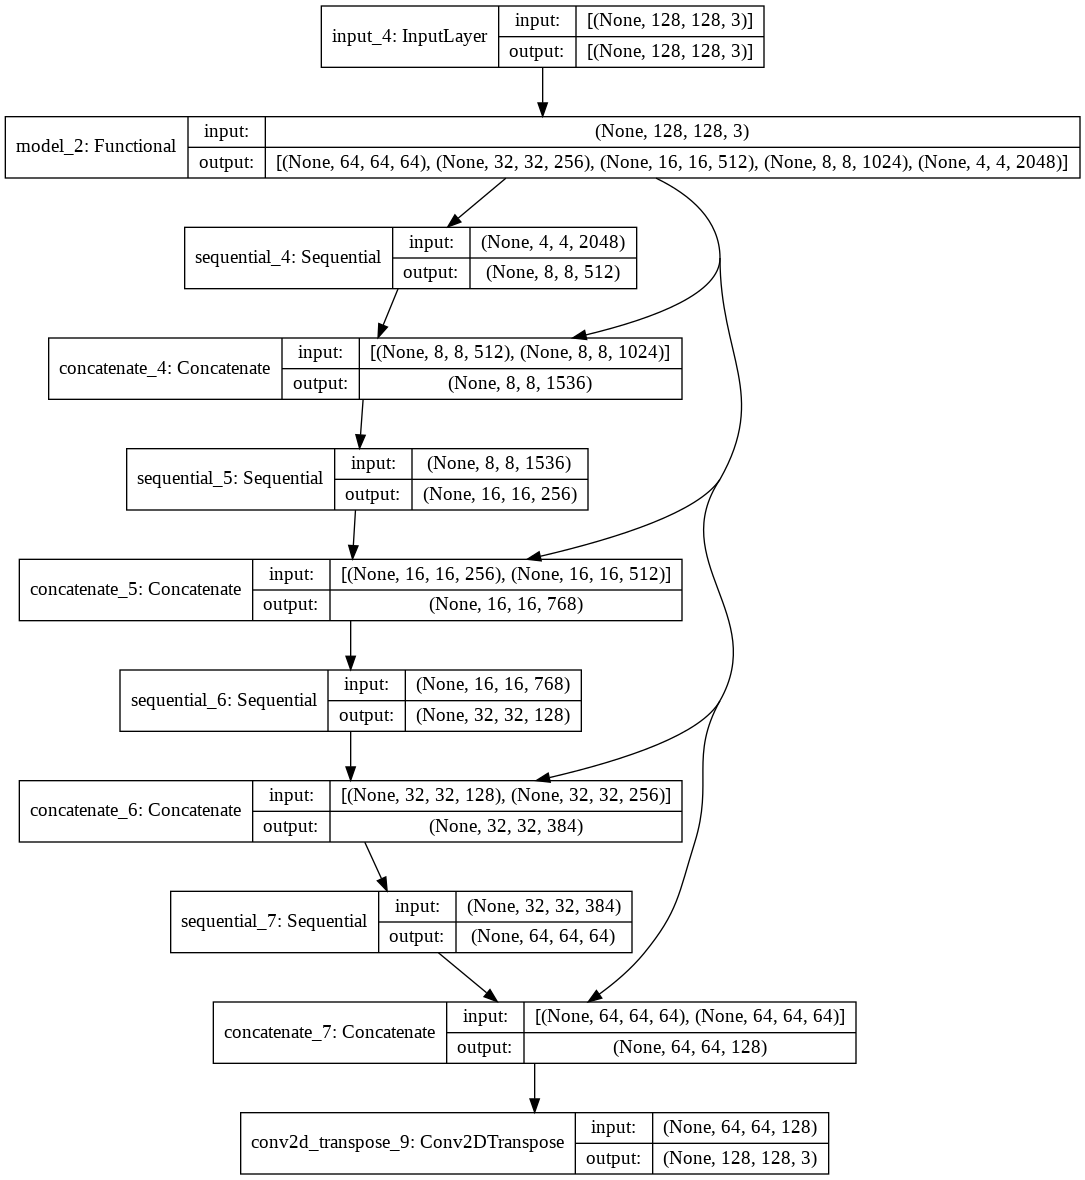

In [30]:
# model_resnet diagram
tf.keras.utils.plot_model(model_resnet, show_shapes=True)

In [31]:
# summary of the unet model
model_resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            [(None, 64, 64, 64), 23587712    input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 512)    9439232     model_2[0][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 8, 8, 1536)   0           sequential_4[0][0]               
                                                                 model_2[0][3]              

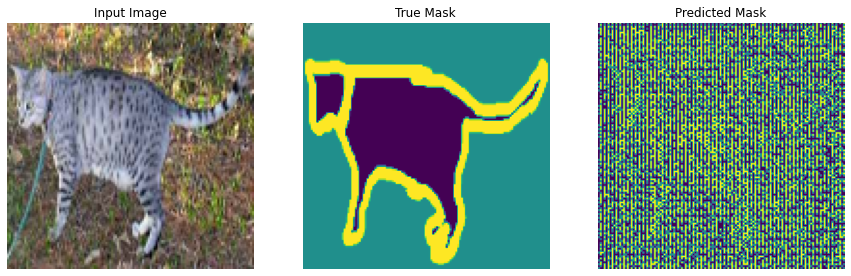

In [32]:
# untrained model predictions

def show_predictions_rn(dataset=None, num=0):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_resnet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_resnet.predict(sample_image[tf.newaxis, ...]))])

show_predictions_rn()

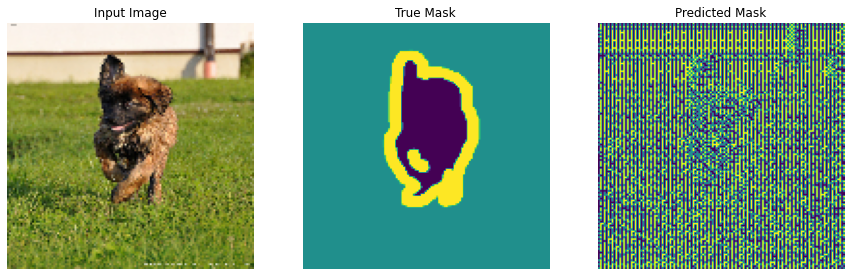

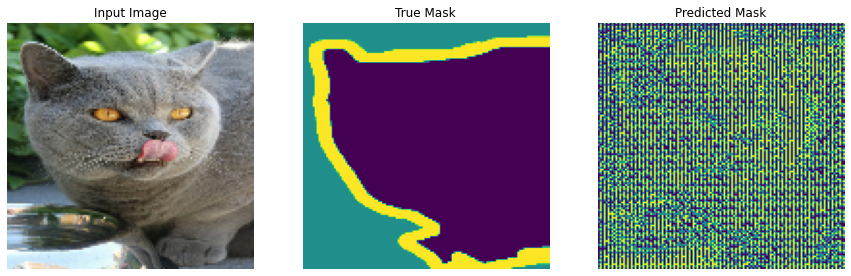

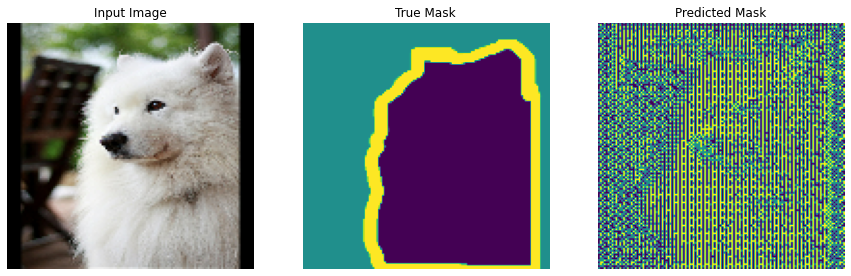

In [33]:
# results of untrained net on test images
show_predictions_rn(test_dataset, 3)

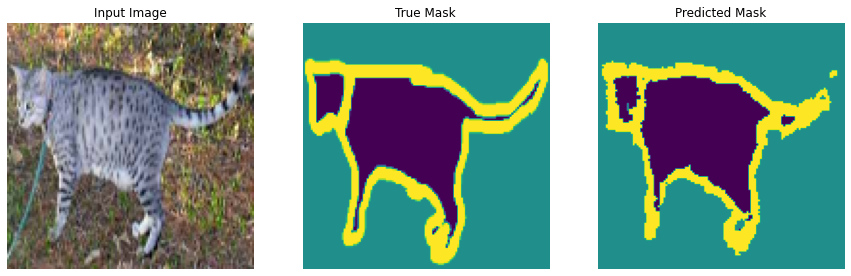


Sample Prediction after epoch 20



In [34]:
# model_resnet training

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

resnet_history = model_resnet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

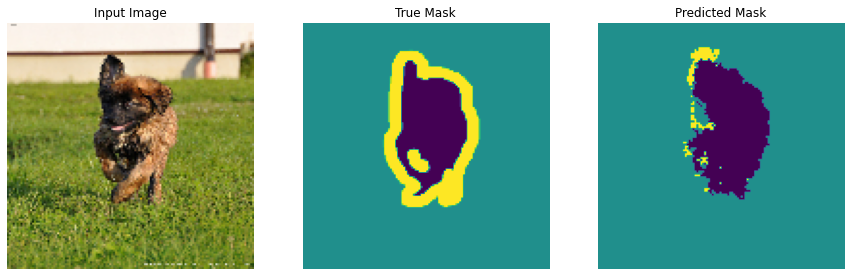

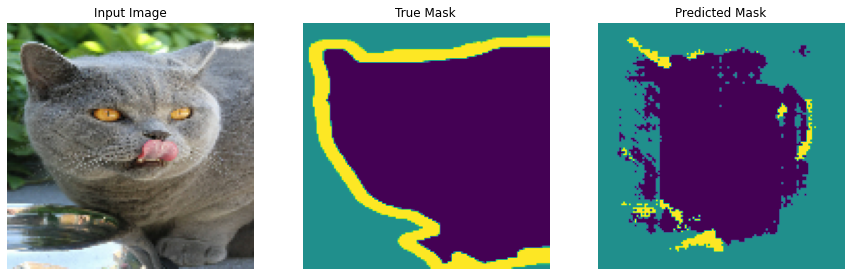

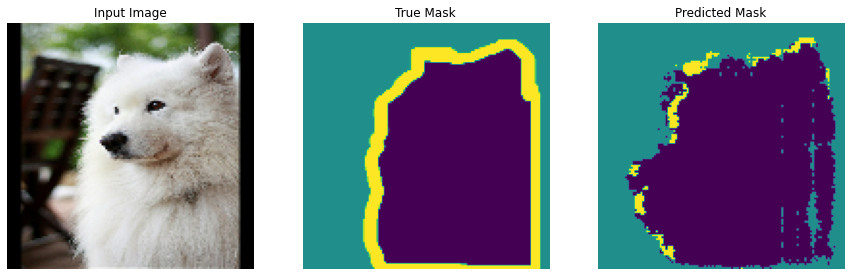

In [35]:
# trained unet predictions
show_predictions_rn(test_dataset, 3)

# Model Evaluation

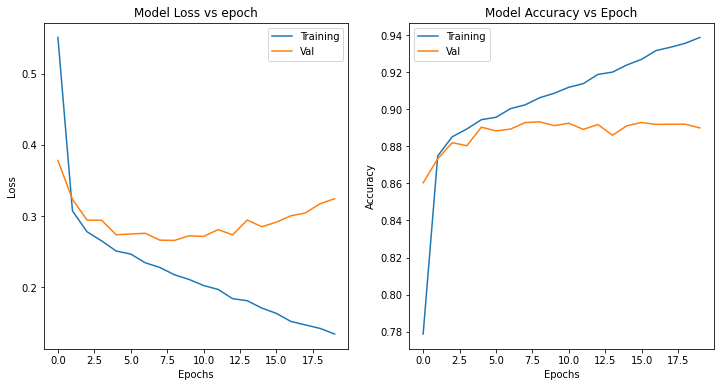

In [36]:
# unet loss and accuracy graphs against epochs
h = unet_history

# loss plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h.history['loss'], label='Training')
plt.plot(h.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

# accuracy plot
plt.subplot(1,2,2)
plt.plot(h.history['accuracy'], label='Training')
plt.plot(h.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

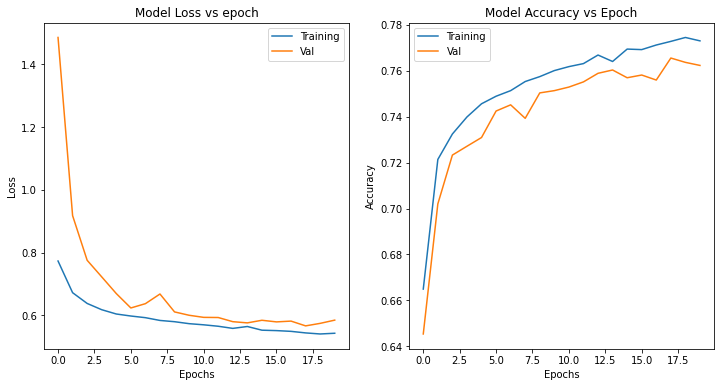

In [37]:
# resnet loss and accuracy graphs against epochs
h2 = resnet_history

# loss plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h2.history['loss'], label='Training')
plt.plot(h2.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

# accuracy plot
plt.subplot(1,2,2)
plt.plot(h2.history['accuracy'], label='Training')
plt.plot(h2.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()